# Project 1 - Breakout identification and direction
---
In this project, we will attempt to create two models that will identify when there is the highest likelihood for a breakout occurring, and train a second model that will signal us which type of position to take.

[...]

First, we will start by loading our data.

In [1]:
import pandas as pd

# Load the QQQ data

qqq_data = pd.read_csv('QQQ_2025-03-02_datasets\QQQ_train_data.csv')
qqq_data_test = pd.read_csv('QQQ_2025-03-02_datasets\QQQ_test_data.csv')
# Display the first few rows to examine the data
qqq_data.head()

<>:5: SyntaxWarning: invalid escape sequence '\Q'
<>:6: SyntaxWarning: invalid escape sequence '\Q'
<>:5: SyntaxWarning: invalid escape sequence '\Q'
<>:6: SyntaxWarning: invalid escape sequence '\Q'
C:\Users\nicot\AppData\Local\Temp\ipykernel_33804\2575877769.py:5: SyntaxWarning: invalid escape sequence '\Q'
  qqq_data = pd.read_csv('QQQ_2025-03-02_datasets\QQQ_train_data.csv')
C:\Users\nicot\AppData\Local\Temp\ipykernel_33804\2575877769.py:6: SyntaxWarning: invalid escape sequence '\Q'
  qqq_data_test = pd.read_csv('QQQ_2025-03-02_datasets\QQQ_test_data.csv')


,timestamp,volume,high,low,close,open,vwap
0,2024-03-05 09:30:00+00:00,42702,441.00,440.6300,441.00,440.70,440.859391
1,2024-03-05 09:35:00+00:00,1967726,440.95,439.4904,439.54,440.94,440.123686
2,2024-03-05 09:40:00+00:00,1423247,439.79,439.0900,439.68,439.52,439.506483
3,2024-03-05 09:45:00+00:00,986065,439.81,439.0600,439.33,439.69,439.459675
4,2024-03-05 09:50:00+00:00,1185201,439.32,438.3100,438.83,439.32,438.852920


Next, let's import all the necessary libraries.

In [2]:
import numpy as np
import talib
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import numpy as np
import talib
import matplotlib.pyplot as plt

Next, we want to set up the indicators we will be using for our model. We want to include as many indicators as we can. We will later on test for multicollinearity.

In [3]:
# Convert timestamp to datetime
qqq_data['timestamp'] = pd.to_datetime(qqq_data['timestamp'])

# Set timestamp as index
qqq_data.set_index('timestamp', inplace=True)

# --- Trend Indicators ---
# Moving Averages
qqq_data['sma_20'] = talib.SMA(qqq_data['close'], timeperiod=20)
qqq_data['sma_50'] = talib.SMA(qqq_data['close'], timeperiod=50)
qqq_data['sma_200'] = talib.SMA(qqq_data['close'], timeperiod=200)
qqq_data['ema_20'] = talib.EMA(qqq_data['close'], timeperiod=20)

# MACD
macd, macd_signal, macd_hist = talib.MACD(qqq_data['close'])
qqq_data['macd'] = macd
qqq_data['macd_signal'] = macd_signal
qqq_data['macd_hist'] = macd_hist

# ADX - Trend Strength
qqq_data['adx'] = talib.ADX(qqq_data['high'], qqq_data['low'], qqq_data['close'], timeperiod=14)

# --- Momentum Indicators ---
# RSI
qqq_data['rsi'] = talib.RSI(qqq_data['close'], timeperiod=14)

# Stochastic Oscillator
qqq_data['slowk'], qqq_data['slowd'] = talib.STOCH(qqq_data['high'], qqq_data['low'], qqq_data['close'])

# CCI - Commodity Channel Index
qqq_data['cci'] = talib.CCI(qqq_data['high'], qqq_data['low'], qqq_data['close'], timeperiod=14)

# --- Volatility Indicators ---
# Bollinger Bands
upper, middle, lower = talib.BBANDS(qqq_data['close'], timeperiod=20)
qqq_data['bb_upper'] = upper
qqq_data['bb_middle'] = middle
qqq_data['bb_lower'] = lower
qqq_data['bb_width'] = (upper - lower) / middle  # Bollinger Band Width

# ATR - Average True Range
qqq_data['atr'] = talib.ATR(qqq_data['high'], qqq_data['low'], qqq_data['close'], timeperiod=14)

# --- Volume Indicators ---
# OBV - On-Balance Volume
qqq_data['obv'] = talib.OBV(qqq_data['close'], qqq_data['volume'])

# Volume Rate of Change
qqq_data['volume_roc'] = qqq_data['volume'].pct_change(5)

# --- Price Patterns ---
# Calculate price rate of change
qqq_data['price_roc'] = qqq_data['close'].pct_change(5)

# Daily Returns
qqq_data['daily_return'] = qqq_data['close'].pct_change()

# Intraday volatility (High-Low range)
qqq_data['intraday_vol'] = (qqq_data['high'] - qqq_data['low']) / qqq_data['close']

# Price distance from moving average
qqq_data['dist_from_sma20'] = (qqq_data['close'] - qqq_data['sma_20']) / qqq_data['sma_20']
qqq_data['dist_from_sma50'] = (qqq_data['close'] - qqq_data['sma_50']) / qqq_data['sma_50']

# Drop rows with NaN values (from the calculation of indicators)
qqq_data.dropna(inplace=True)

# Display the first few rows with indicators
qqq_data.head()

,volume,high,low,close,open,vwap,sma_20,sma_50,sma_200,ema_20,...,bb_lower,bb_width,atr,obv,volume_roc,price_roc,daily_return,intraday_vol,dist_from_sma20,dist_from_sma50
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-07 12:55:00+00:00,298961,445.57,445.210,445.410,445.310,445.424181,445.199495,443.302940,439.206934,445.042634,...,444.516952,0.003066,0.465728,3019441.0,-0.191709,-0.000067,0.000247,0.000808,0.000473,0.004753
2024-03-07 13:00:00+00:00,300770,445.50,445.210,445.485,445.405,445.312092,445.250745,443.455440,439.229359,445.084764,...,444.648839,0.002704,0.453176,3320211.0,-0.089721,0.000279,0.000168,0.000651,0.000526,0.004577
2024-03-07 13:05:00+00:00,221374,445.65,445.390,445.410,445.480,445.516744,445.275245,443.599240,439.258710,445.115739,...,444.689511,0.002631,0.439378,3098837.0,-0.196605,-0.000213,-0.000168,0.000584,0.000303,0.004082
2024-03-07 13:10:00+00:00,243248,445.62,445.050,445.550,445.420,445.342260,445.306245,443.755240,439.288060,445.157097,...,444.731354,0.002582,0.448708,3342085.0,-0.408415,0.000357,0.000314,0.001279,0.000547,0.004044
2024-03-07 13:15:00+00:00,280229,445.75,445.365,445.510,445.570,445.623364,445.351765,443.898438,439.318960,445.190707,...,444.871510,0.002157,0.444158,3061856.0,-0.007030,0.000472,-0.000090,0.000864,0.000355,0.003630


We can now train our model using the above indicators. Our first model is to identify a breakout. To do this, we need to set our target variable such that conditions are breakouts. For this, we will create an extra column in our dataset for 'breakout'. This value is 1 if we identify a positive breakout, -1 for negative breakout and 0 otherwise. 

Breakout distribution:
breakout
 0    15529
-1      382
 1      317
Name: count, dtype: int64
Positive breakouts: 317
Negative breakouts: 382
No breakouts: 15529
Training data shape after resampling: (37269, 19)
Class distribution after resampling: breakout
 0    12423
-1    12423
 1    12423
Name: count, dtype: int64
Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\nicot\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\nicot\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\nicot\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nicot\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1038

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

          -1       0.48      0.77      0.59        77
           0       0.99      0.96      0.97      3106
           1       0.44      0.75      0.55        63

    accuracy                           0.95      3246
   macro avg       0.63      0.82      0.70      3246
weighted avg       0.97      0.95      0.96      3246


Confusion Matrix:
[[  59   18    0]
 [  64 2981   61]
 [   0   16   47]]

Top 10 Feature Importances:
            Feature  Importance
10              cci    0.228498
7               rsi    0.143891
14     daily_return    0.131860
18       volume_roc    0.101071
16  dist_from_sma20    0.097643
13        price_roc    0.095299
5         macd_hist    0.048618
8             slowk    0.030615
17  dist_from_sma50    0.023549
15     intraday_vol    0.017001


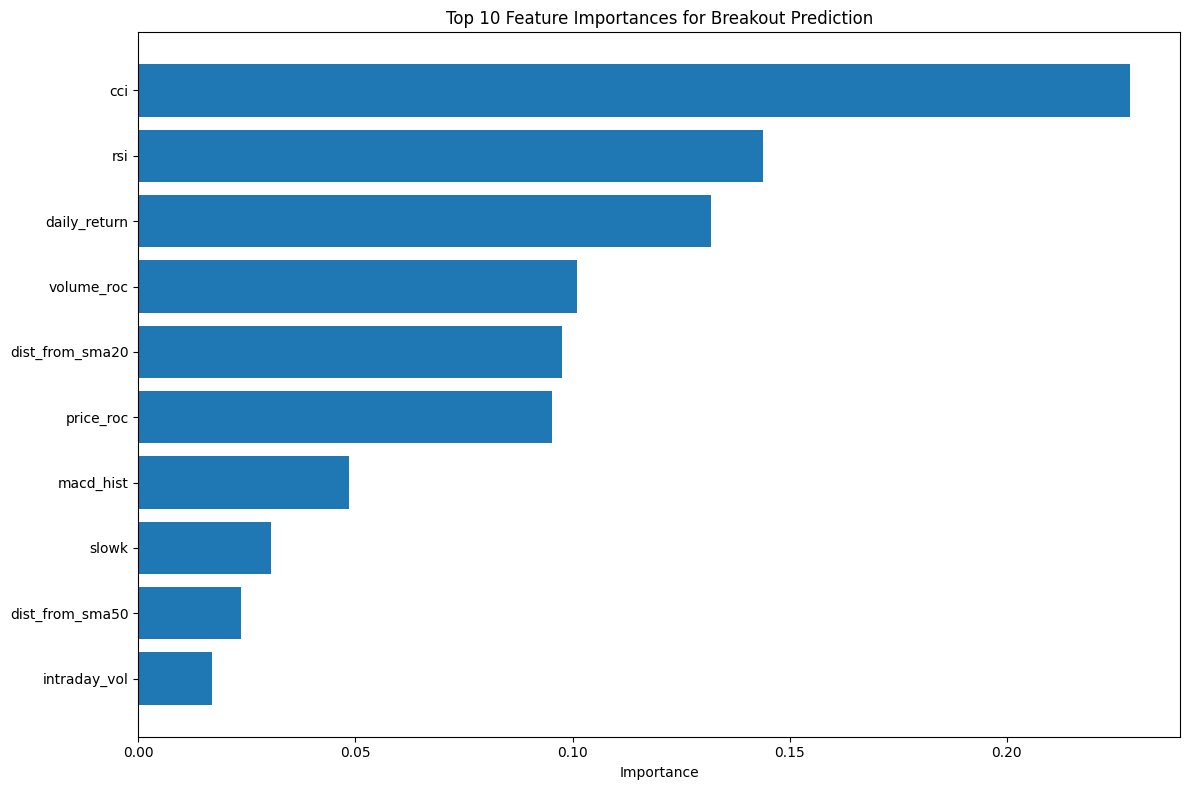

Model and scaler saved to disk.

Predicting on last 5 data points:
Actual breakouts: [ 0  0  0  0 -1]
Predicted breakouts: [ 0  0  0  0 -1]


In [4]:
# Define breakout conditions
# A breakout occurs when price moves significantly outside a range with increased volume

# 1. Define volume spike (increased volume)
qqq_data['vol_ma'] = qqq_data['volume'].rolling(window=20).mean()
qqq_data['vol_increased'] = qqq_data['volume'] > 1.5 * qqq_data['vol_ma']

# 2. Define price breakouts using Bollinger Bands and price movement
# Positive breakout: price closes above upper Bollinger Band with increased volume
# Negative breakout: price closes below lower Bollinger Band with increased volume
qqq_data['breakout'] = 0  # Default: no breakout

# Positive breakouts
positive_condition = (
    (qqq_data['close'] > qqq_data['bb_upper']) & 
    (qqq_data['vol_increased']) & 
    (qqq_data['close'] > qqq_data['close'].shift(1))  # Current close higher than previous
)
qqq_data.loc[positive_condition, 'breakout'] = 1

# Negative breakouts
negative_condition = (
    (qqq_data['close'] < qqq_data['bb_lower']) & 
    (qqq_data['vol_increased']) & 
    (qqq_data['close'] < qqq_data['close'].shift(1))  # Current close lower than previous
)
qqq_data.loc[negative_condition, 'breakout'] = -1

# Count the breakouts
breakout_counts = qqq_data['breakout'].value_counts()
print(f"Breakout distribution:\n{breakout_counts}")
print(f"Positive breakouts: {sum(qqq_data['breakout'] == 1)}")
print(f"Negative breakouts: {sum(qqq_data['breakout'] == -1)}")
print(f"No breakouts: {sum(qqq_data['breakout'] == 0)}")

# Select features (excluding target and other non-feature columns)
feature_columns = [
    'sma_20', 'sma_50', 'ema_20', 'macd', 'macd_signal', 'macd_hist', 
    'adx', 'rsi', 'slowk', 'slowd', 'cci', 'bb_width', 'atr', 
    'price_roc', 'daily_return', 'intraday_vol', 'dist_from_sma20', 'dist_from_sma50',
    'volume_roc'
]

X = qqq_data[feature_columns]
y = qqq_data['breakout']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Training data shape after resampling: {X_train_resampled.shape}")
print(f"Class distribution after resampling: {pd.Series(y_train_resampled).value_counts()}")

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Parameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate the model
y_pred = best_rf.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Feature importance
feature_importances = pd.DataFrame(
    {'Feature': feature_columns, 'Importance': best_rf.feature_importances_}
).sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importances.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances for Breakout Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save the model and scaler for future use
import pickle
with open('breakout_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
with open('breakout_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler saved to disk.")

# Create a function for predicting breakouts on new data
def predict_breakout(new_data):
    """
    Predict breakout on new data.
    
    Args:
        new_data: DataFrame with the same features as used in training
    
    Returns:
        Array of predictions: 1 (positive breakout), -1 (negative breakout), 0 (no breakout)
    """
    # Ensure all required features are present
    missing_features = [feat for feat in feature_columns if feat not in new_data.columns]
    if missing_features:
        raise ValueError(f"Missing features in input data: {missing_features}")
    
    # Extract features and scale
    X_new = new_data[feature_columns]
    X_new_scaled = scaler.transform(X_new)
    
    # Make predictions
    return best_rf.predict(X_new_scaled)

# Example: Predict on the last 5 data points
last_samples = qqq_data.iloc[-5:].copy()
print("\nPredicting on last 5 data points:")
print("Actual breakouts:", last_samples['breakout'].values)
print("Predicted breakouts:", predict_breakout(last_samples))

Let's visualize the data.

Confusion Matrix on Test Data:
[[  55   15    0]
 [  49 2764   26]
 [   0   21   31]]

Classification Report on Test Data:
              precision    recall  f1-score   support

          -1       0.53      0.79      0.63        70
           0       0.99      0.97      0.98      2839
           1       0.54      0.60      0.57        52

    accuracy                           0.96      2961
   macro avg       0.69      0.79      0.73      2961
weighted avg       0.97      0.96      0.96      2961


Total predictions: 2961
Correct predictions: 2850 (96.25%)
Incorrect predictions: 111 (3.75%)

Positive breakouts: 52 actual, 31 correctly identified (59.62%)
Negative breakouts: 70 actual, 55 correctly identified (78.57%)
No breakouts: 2839 actual, 2764 correctly identified (97.36%)


C:\Users\nicot\AppData\Local\Temp\ipykernel_33804\2870472657.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq_data_test_clean['predicted_breakout'] = y_test_pred


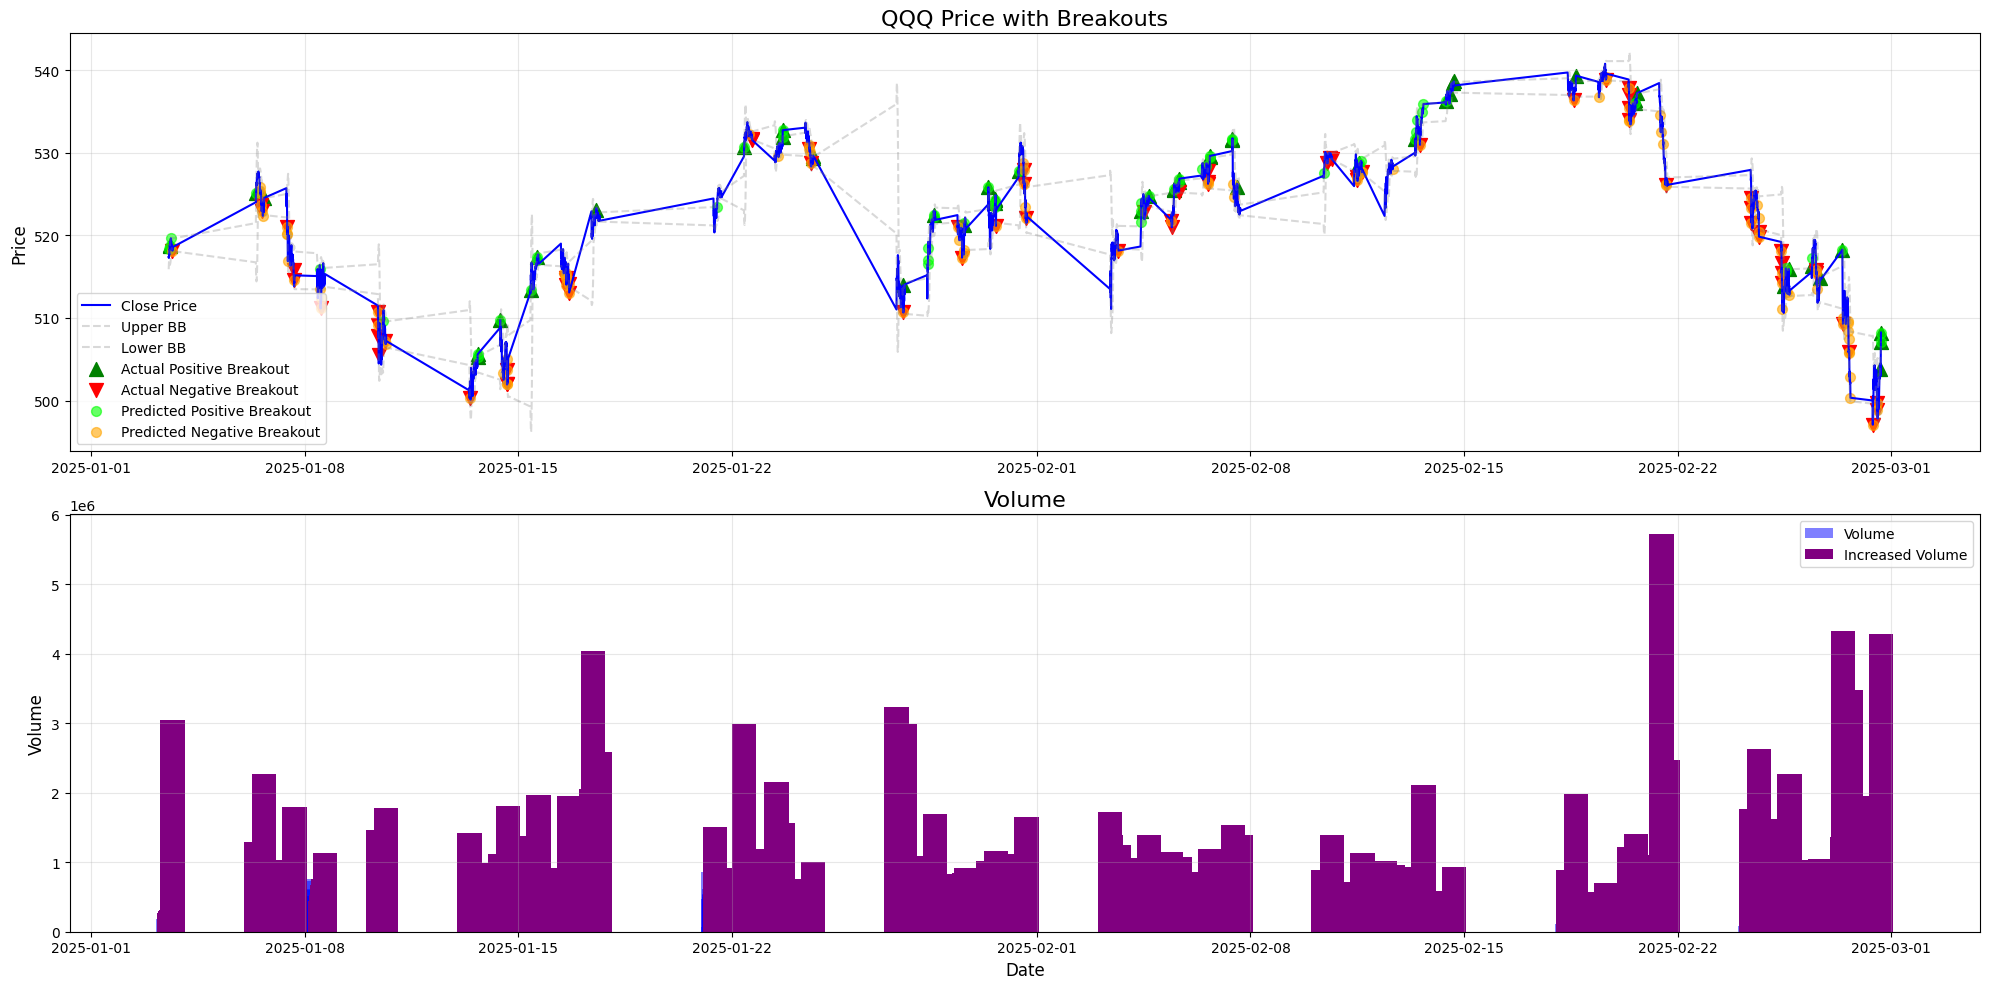

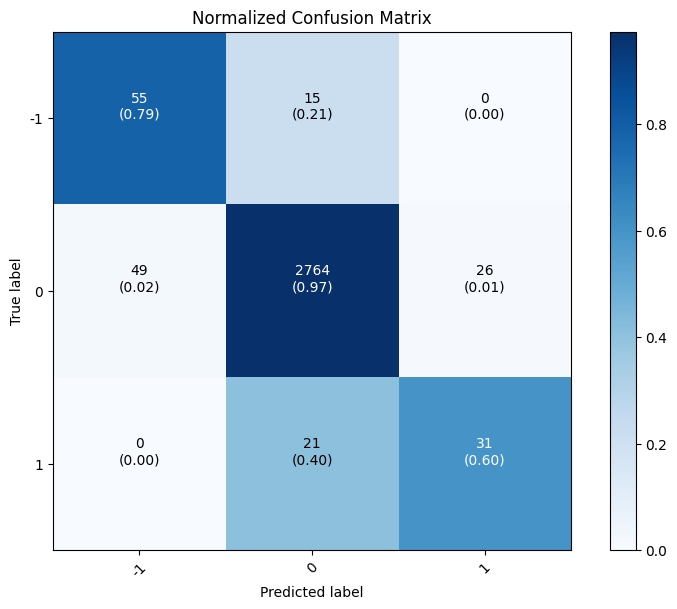

In [5]:
# First, process the test data the same way we did the training data
# Convert timestamp to datetime
qqq_data_test['timestamp'] = pd.to_datetime(qqq_data_test['timestamp'])

# Set timestamp as index
qqq_data_test.set_index('timestamp', inplace=True)

# Calculate the same technical indicators as in the training data
# --- Trend Indicators ---
# Moving Averages
qqq_data_test['sma_20'] = talib.SMA(qqq_data_test['close'], timeperiod=20)
qqq_data_test['sma_50'] = talib.SMA(qqq_data_test['close'], timeperiod=50)
qqq_data_test['sma_200'] = talib.SMA(qqq_data_test['close'], timeperiod=200)
qqq_data_test['ema_20'] = talib.EMA(qqq_data_test['close'], timeperiod=20)

# MACD
macd, macd_signal, macd_hist = talib.MACD(qqq_data_test['close'])
qqq_data_test['macd'] = macd
qqq_data_test['macd_signal'] = macd_signal
qqq_data_test['macd_hist'] = macd_hist

# ADX - Trend Strength
qqq_data_test['adx'] = talib.ADX(qqq_data_test['high'], qqq_data_test['low'], qqq_data_test['close'], timeperiod=14)

# --- Momentum Indicators ---
# RSI
qqq_data_test['rsi'] = talib.RSI(qqq_data_test['close'], timeperiod=14)

# Stochastic Oscillator
qqq_data_test['slowk'], qqq_data_test['slowd'] = talib.STOCH(qqq_data_test['high'], qqq_data_test['low'], qqq_data_test['close'])

# CCI - Commodity Channel Index
qqq_data_test['cci'] = talib.CCI(qqq_data_test['high'], qqq_data_test['low'], qqq_data_test['close'], timeperiod=14)

# --- Volatility Indicators ---
# Bollinger Bands
upper, middle, lower = talib.BBANDS(qqq_data_test['close'], timeperiod=20)
qqq_data_test['bb_upper'] = upper
qqq_data_test['bb_middle'] = middle
qqq_data_test['bb_lower'] = lower
qqq_data_test['bb_width'] = (upper - lower) / middle  # Bollinger Band Width

# ATR - Average True Range
qqq_data_test['atr'] = talib.ATR(qqq_data_test['high'], qqq_data_test['low'], qqq_data_test['close'], timeperiod=14)

# --- Volume Indicators ---
# OBV - On-Balance Volume
qqq_data_test['obv'] = talib.OBV(qqq_data_test['close'], qqq_data_test['volume'])

# Volume Rate of Change
qqq_data_test['volume_roc'] = qqq_data_test['volume'].pct_change(5)

# --- Price Patterns ---
# Calculate price rate of change
qqq_data_test['price_roc'] = qqq_data_test['close'].pct_change(5)

# Daily Returns
qqq_data_test['daily_return'] = qqq_data_test['close'].pct_change()

# Intraday volatility (High-Low range)
qqq_data_test['intraday_vol'] = (qqq_data_test['high'] - qqq_data_test['low']) / qqq_data_test['close']

# Price distance from moving average
qqq_data_test['dist_from_sma20'] = (qqq_data_test['close'] - qqq_data_test['sma_20']) / qqq_data_test['sma_20']
qqq_data_test['dist_from_sma50'] = (qqq_data_test['close'] - qqq_data_test['sma_50']) / qqq_data_test['sma_50']

# Calculate volume moving average for breakout identification
qqq_data_test['vol_ma'] = qqq_data_test['volume'].rolling(window=20).mean()
qqq_data_test['vol_increased'] = qqq_data_test['volume'] > 1.5 * qqq_data_test['vol_ma']

# Identify actual breakouts using the same criteria as in training
qqq_data_test['breakout'] = 0  # Default: no breakout

# Positive breakouts
positive_condition = (
    (qqq_data_test['close'] > qqq_data_test['bb_upper']) & 
    (qqq_data_test['vol_increased']) & 
    (qqq_data_test['close'] > qqq_data_test['close'].shift(1))
)
qqq_data_test.loc[positive_condition, 'breakout'] = 1

# Negative breakouts
negative_condition = (
    (qqq_data_test['close'] < qqq_data_test['bb_lower']) & 
    (qqq_data_test['vol_increased']) & 
    (qqq_data_test['close'] < qqq_data_test['close'].shift(1))
)
qqq_data_test.loc[negative_condition, 'breakout'] = -1

# Drop NaN values for prediction
qqq_data_test_clean = qqq_data_test.dropna()

# Make predictions using the trained model
X_test = qqq_data_test_clean[feature_columns]
X_test_scaled = scaler.transform(X_test)
y_test_actual = qqq_data_test_clean['breakout']
y_test_pred = best_rf.predict(X_test_scaled)

# Add predictions to the dataframe
qqq_data_test_clean['predicted_breakout'] = y_test_pred

# Calculate prediction statistics
cm_test = confusion_matrix(y_test_actual, y_test_pred)
print("Confusion Matrix on Test Data:")
print(cm_test)

print("\nClassification Report on Test Data:")
print(classification_report(y_test_actual, y_test_pred))

# Count of correct and incorrect predictions
correct_predictions = sum(y_test_actual == y_test_pred)
incorrect_predictions = sum(y_test_actual != y_test_pred)
total_predictions = len(y_test_actual)

print(f"\nTotal predictions: {total_predictions}")
print(f"Correct predictions: {correct_predictions} ({correct_predictions/total_predictions:.2%})")
print(f"Incorrect predictions: {incorrect_predictions} ({incorrect_predictions/total_predictions:.2%})")

# Count by breakout type
positive_breakouts_actual = sum(y_test_actual == 1)
negative_breakouts_actual = sum(y_test_actual == -1)
no_breakouts_actual = sum(y_test_actual == 0)

positive_breakouts_correct = sum((y_test_actual == 1) & (y_test_pred == 1))
negative_breakouts_correct = sum((y_test_actual == -1) & (y_test_pred == -1))
no_breakouts_correct = sum((y_test_actual == 0) & (y_test_pred == 0))

pos_ratio = f"{positive_breakouts_correct/positive_breakouts_actual:.2%}" if positive_breakouts_actual > 0 else "N/A"
neg_ratio = f"{negative_breakouts_correct/negative_breakouts_actual:.2%}" if negative_breakouts_actual > 0 else "N/A"
no_ratio  = f"{no_breakouts_correct/no_breakouts_actual:.2%}" if no_breakouts_actual > 0 else "N/A"

print(f"\nPositive breakouts: {positive_breakouts_actual} actual, {positive_breakouts_correct} correctly identified ({pos_ratio})")
print(f"Negative breakouts: {negative_breakouts_actual} actual, {negative_breakouts_correct} correctly identified ({neg_ratio})")
print(f"No breakouts: {no_breakouts_actual} actual, {no_breakouts_correct} correctly identified ({no_ratio})")

# Plot the results
plt.figure(figsize=(20, 10))

# Plot 1: Price Chart with Breakout Points
ax1 = plt.subplot(211)
ax1.plot(qqq_data_test_clean.index, qqq_data_test_clean['close'], label='Close Price', color='blue')
ax1.plot(qqq_data_test_clean.index, qqq_data_test_clean['bb_upper'], label='Upper BB', color='gray', linestyle='--', alpha=0.3)
ax1.plot(qqq_data_test_clean.index, qqq_data_test_clean['bb_lower'], label='Lower BB', color='gray', linestyle='--', alpha=0.3)

# Mark actual positive breakouts
positive_breakouts = qqq_data_test_clean[qqq_data_test_clean['breakout'] == 1]
ax1.scatter(positive_breakouts.index, positive_breakouts['close'], color='green', label='Actual Positive Breakout', marker='^', s=100)

# Mark actual negative breakouts
negative_breakouts = qqq_data_test_clean[qqq_data_test_clean['breakout'] == -1]
ax1.scatter(negative_breakouts.index, negative_breakouts['close'], color='red', label='Actual Negative Breakout', marker='v', s=100)

# Mark predicted positive breakouts
pos_pred = qqq_data_test_clean[qqq_data_test_clean['predicted_breakout'] == 1]
ax1.scatter(pos_pred.index, pos_pred['close'], color='lime', label='Predicted Positive Breakout', marker='o', s=50, alpha=0.6)

# Mark predicted negative breakouts
neg_pred = qqq_data_test_clean[qqq_data_test_clean['predicted_breakout'] == -1]
ax1.scatter(neg_pred.index, neg_pred['close'], color='orange', label='Predicted Negative Breakout', marker='o', s=50, alpha=0.6)

# Formatting
ax1.set_title('QQQ Price with Breakouts', fontsize=16)
ax1.set_ylabel('Price', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best')

# Plot 2: Volume with Increased Volume Highlighted
ax2 = plt.subplot(212, sharex=ax1)
ax2.bar(qqq_data_test_clean.index, qqq_data_test_clean['volume'], color='blue', alpha=0.5, label='Volume')
# Highlight increased volume
increased_vol = qqq_data_test_clean[qqq_data_test_clean['vol_increased']]
ax2.bar(increased_vol.index, increased_vol['volume'], color='purple', label='Increased Volume')

ax2.set_title('Volume', fontsize=16)
ax2.set_ylabel('Volume', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

plt.tight_layout()
plt.show()

# Create a separate figure for confusion matrix visualization
plt.figure(figsize=(8, 6))
classes = [-1, 0, 1]
cm_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = cm_normalized.max() / 2
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(j, i, f'{cm_test[i, j]}\n({cm_normalized[i, j]:.2f})',
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

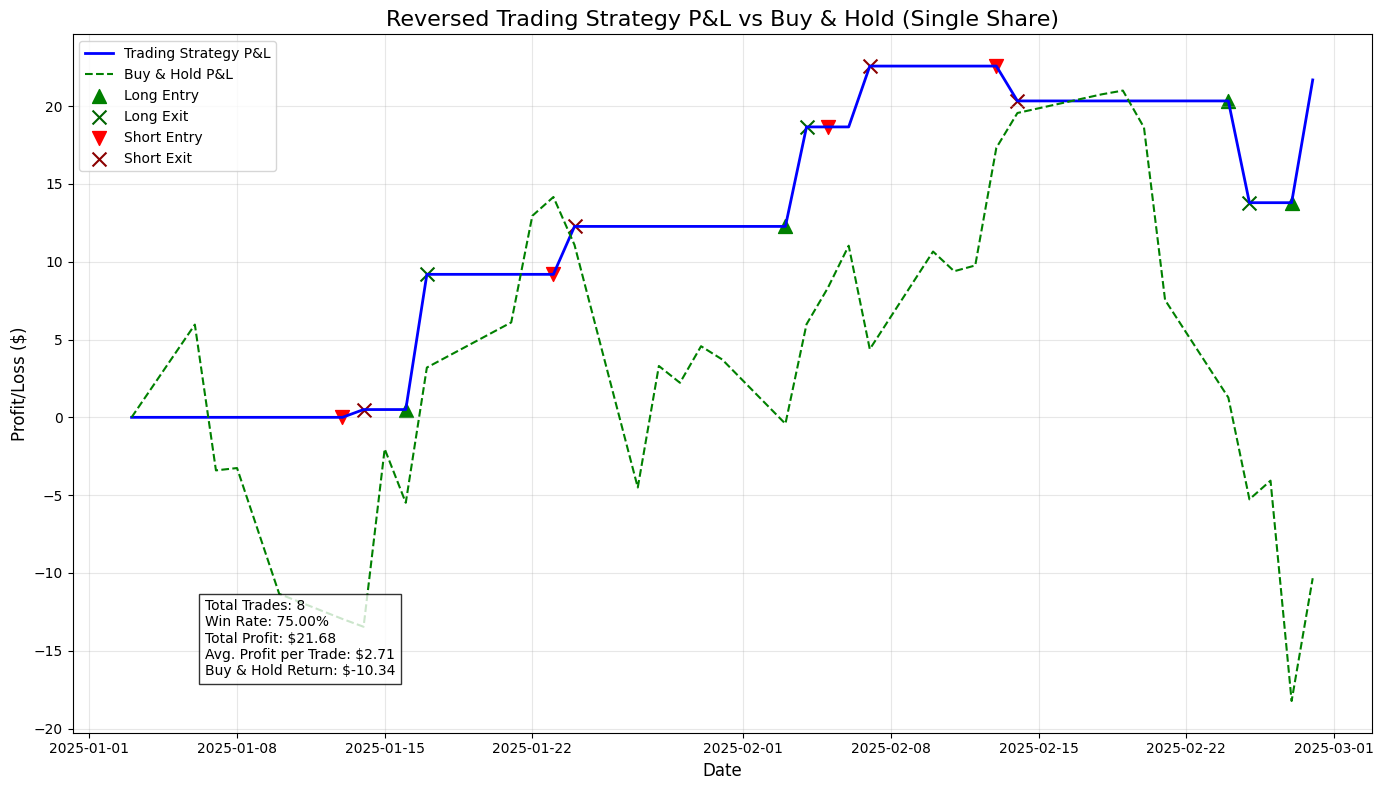


Trade Statistics:
Number of trades: 8
Win rate: 75.00%
Average P&L: $2.71
Total P&L: $21.68

Top 5 trades by P&L:
                 Entry Date                 Exit Date Position    PnL  \
1 2025-01-16 00:00:00+00:00 2025-01-17 00:00:00+00:00     Long  8.690   
7 2025-02-27 00:00:00+00:00 2025-02-28 00:00:00+00:00     Long  7.890   
3 2025-02-03 00:00:00+00:00 2025-02-04 00:00:00+00:00     Long  6.395   
4 2025-02-05 00:00:00+00:00 2025-02-07 00:00:00+00:00    Short  3.910   
2 2025-01-23 00:00:00+00:00 2025-01-24 00:00:00+00:00    Short  3.080   

   Return %  
1  1.693726  
7  1.576959  
3  1.234211  
4  0.742147  
2  0.578165  

Bottom 5 trades by P&L:
                 Entry Date                 Exit Date Position   PnL  Return %
6 2025-02-24 00:00:00+00:00 2025-02-25 00:00:00+00:00     Long -6.54 -1.258104
5 2025-02-13 00:00:00+00:00 2025-02-14 00:00:00+00:00    Short -2.24 -0.418004
0 2025-01-13 00:00:00+00:00 2025-01-14 00:00:00+00:00    Short  0.50  0.098892
2 2025-01-23 00:00:00

In [6]:
# Resample the test data to daily timeframe for easier visualization
daily_data = qqq_data_test_clean.resample('D').last().dropna()

# Create a copy of the daily data for our simulation
trade_simulation = daily_data[['close', 'predicted_breakout']].copy()

# Initialize columns for simulation
trade_simulation['position'] = 0  # 0: no position, 1: long, -1: short
trade_simulation['entry_price'] = 0.0
trade_simulation['daily_pnl'] = 0.0
trade_simulation['cumulative_pnl'] = 0.0

# Simulate trading based on predicted breakouts (taking OPPOSITE positions)
current_position = 0
entry_price = 0

for i in range(len(trade_simulation)):
    # Get current row data
    close_price = trade_simulation['close'].iloc[i]
    prediction = trade_simulation['predicted_breakout'].iloc[i]
    
    # Update position based on prediction (REVERSED STRATEGY)
    if current_position == 0:  # No position
        if prediction == 1:  # Predicted positive breakout -> SHORT
            current_position = -1
            entry_price = close_price
        elif prediction == -1:  # Predicted negative breakout -> LONG
            current_position = 1
            entry_price = close_price
    
    # Close position if signal changes to neutral
    elif current_position == 1 and prediction == 0:  # Close long position
        current_position = 0
        trade_simulation.at[trade_simulation.index[i], 'daily_pnl'] = close_price - entry_price
    
    elif current_position == -1 and prediction == 0:  # Close short position
        current_position = 0
        trade_simulation.at[trade_simulation.index[i], 'daily_pnl'] = entry_price - close_price
    
    # Update current position and entry price
    trade_simulation.at[trade_simulation.index[i], 'position'] = current_position
    if current_position != 0:
        trade_simulation.at[trade_simulation.index[i], 'entry_price'] = entry_price
    
    # If we still hold a position at the end, calculate unrealized P&L
    if i == len(trade_simulation) - 1 and current_position != 0:
        if current_position == 1:  # Long position
            trade_simulation.at[trade_simulation.index[i], 'daily_pnl'] = close_price - entry_price
        else:  # Short position
            trade_simulation.at[trade_simulation.index[i], 'daily_pnl'] = entry_price - close_price

# Calculate cumulative P&L
trade_simulation['cumulative_pnl'] = trade_simulation['daily_pnl'].cumsum()

# Calculate some trading statistics
total_trades = sum((trade_simulation['position'].shift(1) != trade_simulation['position']) & 
                  (trade_simulation['position'] != 0))
winning_trades = sum(trade_simulation['daily_pnl'] > 0)
losing_trades = sum(trade_simulation['daily_pnl'] < 0)
win_rate = winning_trades / total_trades if total_trades > 0 else 0

total_profit = trade_simulation['daily_pnl'].sum()
average_profit_per_trade = total_profit / total_trades if total_trades > 0 else 0

# Add a buy-and-hold benchmark for comparison
trade_simulation['buy_and_hold'] = daily_data['close'] - daily_data['close'].iloc[0]

# Create a P&L graph
plt.figure(figsize=(14, 8))

# Plot the trading strategy P&L
plt.plot(trade_simulation.index, trade_simulation['cumulative_pnl'], 
         label='Trading Strategy P&L', color='blue', linewidth=2)

# Plot the buy-and-hold benchmark
plt.plot(trade_simulation.index, trade_simulation['buy_and_hold'], 
         label='Buy & Hold P&L', color='green', linestyle='--', linewidth=1.5)

# Add markers for position changes
long_entries = trade_simulation.index[(trade_simulation['position'].shift(1) == 0) & 
                                      (trade_simulation['position'] == 1)]
long_exits = trade_simulation.index[(trade_simulation['position'].shift(1) == 1) & 
                                    (trade_simulation['position'] == 0)]
short_entries = trade_simulation.index[(trade_simulation['position'].shift(1) == 0) & 
                                       (trade_simulation['position'] == -1)]
short_exits = trade_simulation.index[(trade_simulation['position'].shift(1) == -1) & 
                                     (trade_simulation['position'] == 0)]

plt.scatter(long_entries, trade_simulation.loc[long_entries, 'cumulative_pnl'], 
            marker='^', color='green', s=100, label='Long Entry')
plt.scatter(long_exits, trade_simulation.loc[long_exits, 'cumulative_pnl'], 
            marker='x', color='darkgreen', s=100, label='Long Exit')
plt.scatter(short_entries, trade_simulation.loc[short_entries, 'cumulative_pnl'], 
            marker='v', color='red', s=100, label='Short Entry')
plt.scatter(short_exits, trade_simulation.loc[short_exits, 'cumulative_pnl'], 
            marker='x', color='darkred', s=100, label='Short Exit')

plt.title('Reversed Trading Strategy P&L vs Buy & Hold (Single Share)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Profit/Loss ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Add statistics as text
stats_text = (f"Total Trades: {total_trades}\n"
              f"Win Rate: {win_rate:.2%}\n"
              f"Total Profit: ${total_profit:.2f}\n"
              f"Avg. Profit per Trade: ${average_profit_per_trade:.2f}\n"
              f"Buy & Hold Return: ${trade_simulation['buy_and_hold'].iloc[-1]:.2f}")

plt.figtext(0.15, 0.15, stats_text, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Let's also show a table of trades for detailed analysis
trade_log = []
position_open = False
entry_date = None
entry_price = 0
position_type = None

for i in range(len(trade_simulation)):
    current_date = trade_simulation.index[i]
    close_price = trade_simulation['close'].iloc[i]
    position = trade_simulation['position'].iloc[i]
    prev_position = trade_simulation['position'].iloc[i-1] if i > 0 else 0
    
    # Position opened
    if prev_position == 0 and position != 0:
        position_open = True
        entry_date = current_date
        entry_price = close_price
        position_type = "Long" if position == 1 else "Short"
    
    # Position closed
    elif prev_position != 0 and position == 0:
        exit_date = current_date
        exit_price = close_price
        
        if position_type == "Long":
            pnl = exit_price - entry_price
        else:  # Short
            pnl = entry_price - exit_price
            
        trade_log.append({
            "Entry Date": entry_date,
            "Entry Price": entry_price,
            "Position": position_type,
            "Exit Date": exit_date,
            "Exit Price": exit_price,
            "PnL": pnl,
            "Return %": (pnl / entry_price) * 100
        })
        
        position_open = False

# If position still open at the end
if position_open:
    exit_date = trade_simulation.index[-1]
    exit_price = trade_simulation['close'].iloc[-1]
    
    if position_type == "Long":
        pnl = exit_price - entry_price
    else:  # Short
        pnl = entry_price - exit_price
        
    trade_log.append({
        "Entry Date": entry_date,
        "Entry Price": entry_price,
        "Position": position_type,
        "Exit Date": exit_date,
        "Exit Price": exit_price,
        "PnL": pnl,
        "Return %": (pnl / entry_price) * 100,
        "Note": "Position still open at end of simulation"
    })

# Convert to dataframe and display
trade_df = pd.DataFrame(trade_log)
if len(trade_df) > 0:
    # Sort by entry date
    trade_df = trade_df.sort_values("Entry Date")
    # Calculate descriptive statistics
    print("\nTrade Statistics:")
    print(f"Number of trades: {len(trade_df)}")
    print(f"Win rate: {(trade_df['PnL'] > 0).mean():.2%}")
    print(f"Average P&L: ${trade_df['PnL'].mean():.2f}")
    print(f"Total P&L: ${trade_df['PnL'].sum():.2f}")
    print("\nTop 5 trades by P&L:")
    print(trade_df.sort_values('PnL', ascending=False).head(5)[['Entry Date', 'Exit Date', 'Position', 'PnL', 'Return %']])
    print("\nBottom 5 trades by P&L:")
    print(trade_df.sort_values('PnL').head(5)[['Entry Date', 'Exit Date', 'Position', 'PnL', 'Return %']])
else:
    print("No trades executed in simulation period")

In [7]:
# Load the complete dataset
qqq_complete = pd.read_csv('QQQ_2025-03-01.csv')

# Data preprocessing
qqq_complete['timestamp'] = pd.to_datetime(qqq_complete['timestamp'])
qqq_complete.set_index('timestamp', inplace=True)

# Calculate technical indicators
# --- Trend Indicators ---
qqq_complete['sma_20'] = talib.SMA(qqq_complete['close'], timeperiod=20)
qqq_complete['sma_50'] = talib.SMA(qqq_complete['close'], timeperiod=50)
qqq_complete['sma_200'] = talib.SMA(qqq_complete['close'], timeperiod=200)
qqq_complete['ema_20'] = talib.EMA(qqq_complete['close'], timeperiod=20)

# MACD
macd, macd_signal, macd_hist = talib.MACD(qqq_complete['close'])
qqq_complete['macd'] = macd
qqq_complete['macd_signal'] = macd_signal
qqq_complete['macd_hist'] = macd_hist

# ADX - Trend Strength
qqq_complete['adx'] = talib.ADX(qqq_complete['high'], qqq_complete['low'], qqq_complete['close'], timeperiod=14)

# --- Momentum Indicators ---
qqq_complete['rsi'] = talib.RSI(qqq_complete['close'], timeperiod=14)
qqq_complete['slowk'], qqq_complete['slowd'] = talib.STOCH(qqq_complete['high'], qqq_complete['low'], qqq_complete['close'])
qqq_complete['cci'] = talib.CCI(qqq_complete['high'], qqq_complete['low'], qqq_complete['close'], timeperiod=14)

# --- Volatility Indicators ---
upper, middle, lower = talib.BBANDS(qqq_complete['close'], timeperiod=20)
qqq_complete['bb_upper'] = upper
qqq_complete['bb_middle'] = middle
qqq_complete['bb_lower'] = lower
qqq_complete['bb_width'] = (upper - lower) / middle

qqq_complete['atr'] = talib.ATR(qqq_complete['high'], qqq_complete['low'], qqq_complete['close'], timeperiod=14)

# --- Volume Indicators ---
qqq_complete['obv'] = talib.OBV(qqq_complete['close'], qqq_complete['volume'])
qqq_complete['volume_roc'] = qqq_complete['volume'].pct_change(5)

# --- Price Patterns ---
qqq_complete['price_roc'] = qqq_complete['close'].pct_change(5)
qqq_complete['daily_return'] = qqq_complete['close'].pct_change()
qqq_complete['intraday_vol'] = (qqq_complete['high'] - qqq_complete['low']) / qqq_complete['close']
qqq_complete['dist_from_sma20'] = (qqq_complete['close'] - qqq_complete['sma_20']) / qqq_complete['sma_20']
qqq_complete['dist_from_sma50'] = (qqq_complete['close'] - qqq_complete['sma_50']) / qqq_complete['sma_50']

# Calculate volume moving average for breakout identification
qqq_complete['vol_ma'] = qqq_complete['volume'].rolling(window=20).mean()
qqq_complete['vol_increased'] = qqq_complete['volume'] > 1.5 * qqq_complete['vol_ma']

# Drop NaN values
qqq_complete_clean = qqq_complete.dropna()


In [8]:
# Extract the features from qqq_complete_clean using the same feature_columns
# (feature_columns, scaler, and rf_model are defined in previous cells)
X_complete = qqq_complete_clean[feature_columns]

# Scale the features using the previously fitted scaler
X_complete_scaled = scaler.transform(X_complete)

# Get predictions from the fitted RandomForest model (best_rf)
complete_predictions = best_rf.predict(X_complete_scaled)

# Add the predictions as a new column in the qqq_complete_clean dataframe
qqq_complete_clean['predicted_breakout'] = complete_predictions

# Display the distribution of predicted breakouts
print("Prediction counts:")
print(qqq_complete_clean['predicted_breakout'].value_counts())

Prediction counts:
predicted_breakout
 0    18497
-1      544
 1      426
Name: count, dtype: int64


C:\Users\nicot\AppData\Local\Temp\ipykernel_33804\1012102633.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq_complete_clean['predicted_breakout'] = complete_predictions


C:\Users\nicot\AppData\Local\Temp\ipykernel_33804\908818535.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq_complete_clean['predicted_breakout'] = test_predictions


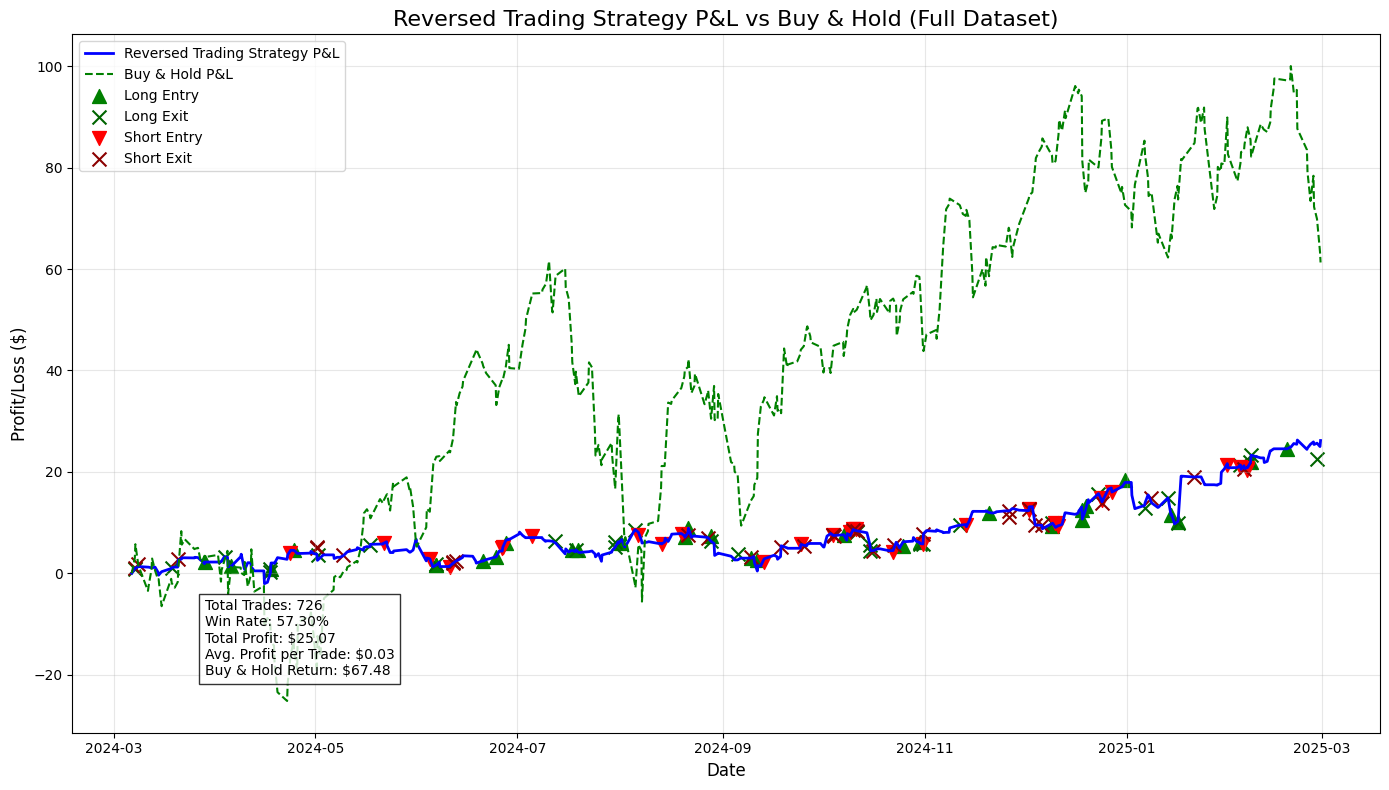


Trade Statistics:
Number of trades: 726
Win rate: 57.30%
Average P&L: $0.03
Total P&L: $25.07

Top 5 trades by P&L:
                   Entry Date                 Exit Date Position    PnL  \
631 2025-01-16 15:55:00+00:00 2025-01-17 09:30:00+00:00     Long  8.780   
556 2024-12-12 16:00:00+00:00 2024-12-13 09:30:00+00:00     Long  3.900   
283 2024-08-05 09:30:00+00:00 2024-08-05 09:35:00+00:00     Long  2.825   
722 2025-02-28 09:35:00+00:00 2025-02-28 09:40:00+00:00     Long  2.715   
571 2024-12-20 09:35:00+00:00 2024-12-20 09:40:00+00:00     Long  2.495   

     Return %  
631  1.707773  
556  0.740741  
283  0.654071  
722  0.546201  
571  0.488933  

Bottom 5 trades by P&L:
                   Entry Date                 Exit Date Position     PnL  \
538 2024-12-03 15:55:00+00:00 2024-12-04 09:30:00+00:00    Short -3.6400   
718 2025-02-27 14:15:00+00:00 2025-02-27 14:40:00+00:00     Long -3.6196   
620 2025-01-13 15:55:00+00:00 2025-01-14 09:30:00+00:00    Short -3.4800   
440 202

In [9]:
# We need to get predictions for the test dataset first
# Apply the model to predict breakouts on the cleaned test data
X_test_features = qqq_complete_clean[feature_columns]
X_test_scaled = scaler.transform(X_test_features)
test_predictions = best_rf.predict(X_test_scaled)

# Add predictions to the test dataframe
qqq_complete_clean['predicted_breakout'] = test_predictions

# Create a copy for our simulation
reversed_simulation = qqq_complete_clean[['close', 'predicted_breakout']].copy()

# Initialize columns for simulation
reversed_simulation['position'] = 0  # 0: no position, 1: long, -1: short
reversed_simulation['entry_price'] = 0.0
reversed_simulation['daily_pnl'] = 0.0
reversed_simulation['cumulative_pnl'] = 0.0

# Simulate trading based on predicted breakouts (REVERSED STRATEGY)
current_position = 0
entry_price = 0

for i in range(len(reversed_simulation)):
    # Get current row data
    close_price = reversed_simulation['close'].iloc[i]
    prediction = reversed_simulation['predicted_breakout'].iloc[i]
    
    # Update position based on prediction (REVERSED STRATEGY)
    if current_position == 0:  # No position
        if prediction == 1:  # Predicted positive breakout -> SHORT
            current_position = -1
            entry_price = close_price
        elif prediction == -1:  # Predicted negative breakout -> LONG
            current_position = 1
            entry_price = close_price
    
    # Close position if signal changes to neutral
    elif current_position == 1 and prediction == 0:  # Close long position
        current_position = 0
        reversed_simulation.at[reversed_simulation.index[i], 'daily_pnl'] = close_price - entry_price
    
    elif current_position == -1 and prediction == 0:  # Close short position
        current_position = 0
        reversed_simulation.at[reversed_simulation.index[i], 'daily_pnl'] = entry_price - close_price
    
    # Update current position and entry price
    reversed_simulation.at[reversed_simulation.index[i], 'position'] = current_position
    if current_position != 0:
        reversed_simulation.at[reversed_simulation.index[i], 'entry_price'] = entry_price
    
    # If we still hold a position at the end, calculate unrealized P&L
    if i == len(reversed_simulation) - 1 and current_position != 0:
        if current_position == 1:  # Long position
            reversed_simulation.at[reversed_simulation.index[i], 'daily_pnl'] = close_price - entry_price
        else:  # Short position
            reversed_simulation.at[reversed_simulation.index[i], 'daily_pnl'] = entry_price - close_price

# Calculate cumulative P&L
reversed_simulation['cumulative_pnl'] = reversed_simulation['daily_pnl'].cumsum()

# Add a buy-and-hold benchmark for comparison
reversed_simulation['buy_and_hold'] = reversed_simulation['close'] - reversed_simulation['close'].iloc[0]

# Calculate some trading statistics
total_trades = sum((reversed_simulation['position'].shift(1) != reversed_simulation['position']) & 
                  (reversed_simulation['position'] != 0))
winning_trades = sum(reversed_simulation['daily_pnl'] > 0)
losing_trades = sum(reversed_simulation['daily_pnl'] < 0)
win_rate = winning_trades / total_trades if total_trades > 0 else 0

total_profit = reversed_simulation['daily_pnl'].sum()
average_profit_per_trade = total_profit / total_trades if total_trades > 0 else 0

# Resample for plotting to avoid overcrowding (use every 50th point)
plot_data = reversed_simulation.iloc[::50].copy()

# Create a P&L graph
plt.figure(figsize=(14, 8))

# Plot the trading strategy P&L
plt.plot(plot_data.index, plot_data['cumulative_pnl'], 
         label='Reversed Trading Strategy P&L', color='blue', linewidth=2)

# Plot the buy-and-hold benchmark
plt.plot(plot_data.index, plot_data['buy_and_hold'], 
         label='Buy & Hold P&L', color='green', linestyle='--', linewidth=1.5)

# Add markers for a subset of position changes to avoid overcrowding
long_entries = reversed_simulation.index[(reversed_simulation['position'].shift(1) == 0) & 
                                      (reversed_simulation['position'] == 1)]
long_exits = reversed_simulation.index[(reversed_simulation['position'].shift(1) == 1) & 
                                    (reversed_simulation['position'] == 0)]
short_entries = reversed_simulation.index[(reversed_simulation['position'].shift(1) == 0) & 
                                       (reversed_simulation['position'] == -1)]
short_exits = reversed_simulation.index[(reversed_simulation['position'].shift(1) == -1) & 
                                     (reversed_simulation['position'] == 0)]

# Sample at most 30 entry/exit points for visualization
sample_size = min(30, len(long_entries))
if sample_size > 0:
    long_entries_sample = np.random.choice(long_entries, size=sample_size, replace=False)
    plt.scatter(long_entries_sample, reversed_simulation.loc[long_entries_sample, 'cumulative_pnl'], 
            marker='^', color='green', s=100, label='Long Entry')

sample_size = min(30, len(long_exits))
if sample_size > 0:
    long_exits_sample = np.random.choice(long_exits, size=sample_size, replace=False)
    plt.scatter(long_exits_sample, reversed_simulation.loc[long_exits_sample, 'cumulative_pnl'], 
            marker='x', color='darkgreen', s=100, label='Long Exit')

sample_size = min(30, len(short_entries))
if sample_size > 0:
    short_entries_sample = np.random.choice(short_entries, size=sample_size, replace=False)
    plt.scatter(short_entries_sample, reversed_simulation.loc[short_entries_sample, 'cumulative_pnl'], 
            marker='v', color='red', s=100, label='Short Entry')

sample_size = min(30, len(short_exits))
if sample_size > 0:
    short_exits_sample = np.random.choice(short_exits, size=sample_size, replace=False)
    plt.scatter(short_exits_sample, reversed_simulation.loc[short_exits_sample, 'cumulative_pnl'], 
            marker='x', color='darkred', s=100, label='Short Exit')

plt.title('Reversed Trading Strategy P&L vs Buy & Hold (Full Dataset)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Profit/Loss ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Add statistics as text
stats_text = (f"Total Trades: {total_trades}\n"
              f"Win Rate: {win_rate:.2%}\n"
              f"Total Profit: ${total_profit:.2f}\n"
              f"Avg. Profit per Trade: ${average_profit_per_trade:.2f}\n"
              f"Buy & Hold Return: ${reversed_simulation['buy_and_hold'].iloc[-1]:.2f}")

plt.figtext(0.15, 0.15, stats_text, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Generate detailed trade log
trade_log = []
position_open = False
entry_date = None
entry_price = 0
position_type = None

for i in range(len(reversed_simulation)):
    current_date = reversed_simulation.index[i]
    close_price = reversed_simulation['close'].iloc[i]
    position = reversed_simulation['position'].iloc[i]
    prev_position = reversed_simulation['position'].iloc[i-1] if i > 0 else 0
    
    # Position opened
    if prev_position == 0 and position != 0:
        position_open = True
        entry_date = current_date
        entry_price = close_price
        position_type = "Long" if position == 1 else "Short"
    
    # Position closed
    elif prev_position != 0 and position == 0:
        exit_date = current_date
        exit_price = close_price
        
        if position_type == "Long":
            pnl = exit_price - entry_price
        else:  # Short
            pnl = entry_price - exit_price
            
        trade_log.append({
            "Entry Date": entry_date,
            "Entry Price": entry_price,
            "Position": position_type,
            "Exit Date": exit_date,
            "Exit Price": exit_price,
            "PnL": pnl,
            "Return %": (pnl / entry_price) * 100
        })
        
        position_open = False

# If position still open at the end
if position_open:
    exit_date = reversed_simulation.index[-1]
    exit_price = reversed_simulation['close'].iloc[-1]
    
    if position_type == "Long":
        pnl = exit_price - entry_price
    else:  # Short
        pnl = entry_price - exit_price
        
    trade_log.append({
        "Entry Date": entry_date,
        "Entry Price": entry_price,
        "Position": position_type,
        "Exit Date": exit_date,
        "Exit Price": exit_price,
        "PnL": pnl,
        "Return %": (pnl / entry_price) * 100,
        "Note": "Position still open at end of simulation"
    })

# Convert to dataframe and display
trade_df = pd.DataFrame(trade_log)
if len(trade_df) > 0:
    # Sort by entry date
    trade_df = trade_df.sort_values("Entry Date")
    # Calculate descriptive statistics
    print("\nTrade Statistics:")
    print(f"Number of trades: {len(trade_df)}")
    print(f"Win rate: {(trade_df['PnL'] > 0).mean():.2%}")
    print(f"Average P&L: ${trade_df['PnL'].mean():.2f}")
    print(f"Total P&L: ${trade_df['PnL'].sum():.2f}")
    print("\nTop 5 trades by P&L:")
    print(trade_df.sort_values('PnL', ascending=False).head(5)[['Entry Date', 'Exit Date', 'Position', 'PnL', 'Return %']])
    print("\nBottom 5 trades by P&L:")
    print(trade_df.sort_values('PnL').head(5)[['Entry Date', 'Exit Date', 'Position', 'PnL', 'Return %']])
else:
    print("No trades executed in simulation period")